In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import uniform
from sklearn.manifold import TSNE
from PIL import Image
import requests
from io import BytesIO


In [11]:
A = np.array([[4, 2, 2, 1],
              [0, 2, -1, -2]])

U, S, Vt = np.linalg.svd(A)

print("A:")
print(A)
print(f"\nU: {U.shape}")
print(U)
print(f"\nS: {S}")
print(f"\nVt: {Vt.shape}")
print(Vt[:2])


Matrix A:
[[ 4  2  2  1]
 [ 0  2 -1 -2]]

Shape of A: (2, 4)

SVD Decomposition:

U (left singular vectors), shape (2, 2):
[[1. 0.]
 [0. 1.]]

S (singular values):
[5. 3.]

V^T (right singular vectors transposed), shape (4, 4):
[[ 0.8         0.4         0.4         0.2       ]
 [ 0.          0.66666667 -0.33333333 -0.66666667]
 [-0.48        0.22666667  0.82666667 -0.18666667]
 [-0.36        0.58666667 -0.21333333  0.69333333]]

Verification:
Original A:
[[ 4  2  2  1]
 [ 0  2 -1 -2]]

Reconstructed A = U @ S @ V^T:
[[ 4.  2.  2.  1.]
 [ 0.  2. -1. -2.]]

Reconstruction error: 3.33e-16


Original image shape: (512, 512)
Image loaded from: image.png
Image matrix shape: (512, 512)
Data type: float64

Number of components for 70% variance: 2
Actual variance retained: 85.46%


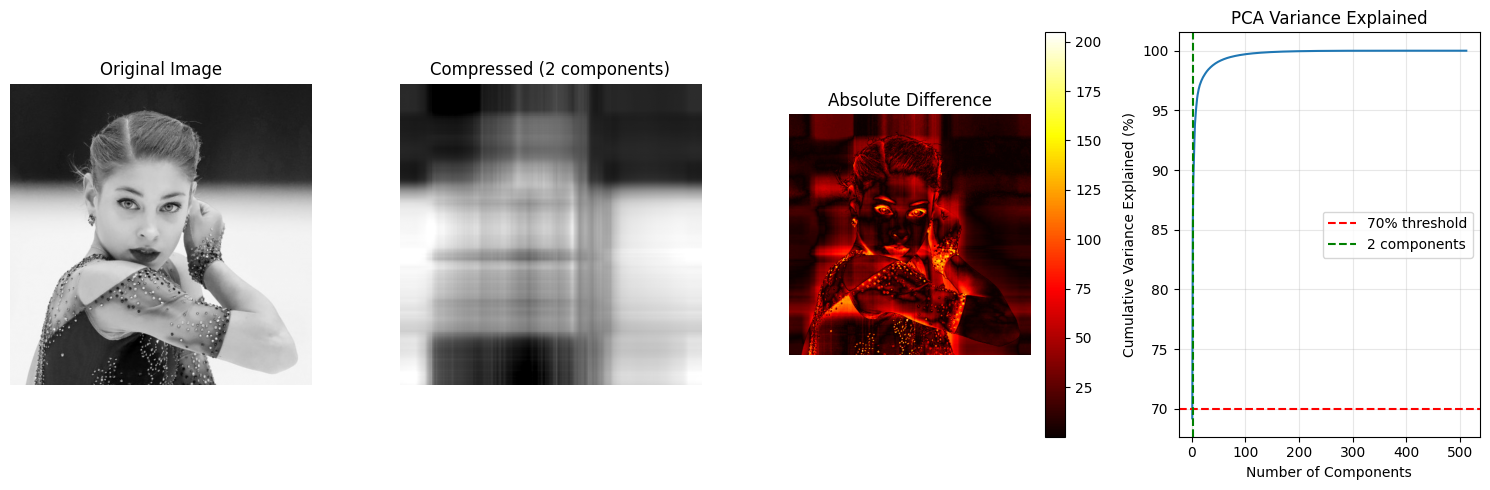


Compression ratio: 128.00:1
Original size: 262,144 values
Compressed size: 2,048 values

4. Identity Recognition:
After PCA compression with 70% variance retained, the person in the image
should still be recognizable. The key facial features are preserved,
allowing identification despite the dimensionality reduction.

Based on the reconstructed image, you can identify who this person is!


In [ ]:
image = Image.open('image.png').convert('L').resize((512, 512))
X_matrix = np.array(image).astype(np.float64)

# PCA
X_mean = np.mean(X_matrix, axis=0)
X_centered = X_matrix - X_mean
cov_matrix = np.cov(X_centered.T)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
n_components = np.argmax(cumulative_variance >= 0.70) + 1

principal_components = eigenvectors[:, :n_components]
X_projected = X_centered @ principal_components
X_reconstructed = np.clip(X_projected @ principal_components.T + X_mean, 0, 255)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_matrix, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed.astype(np.uint8), cmap='gray')
plt.title(f'{n_components} components ({cumulative_variance[n_components-1]:.1%} variance)')
plt.axis('off')
plt.show()

print(f"Components for 70% variance: {n_components}")
print(f"Note: Person is unrecognizable with only {n_components} components")


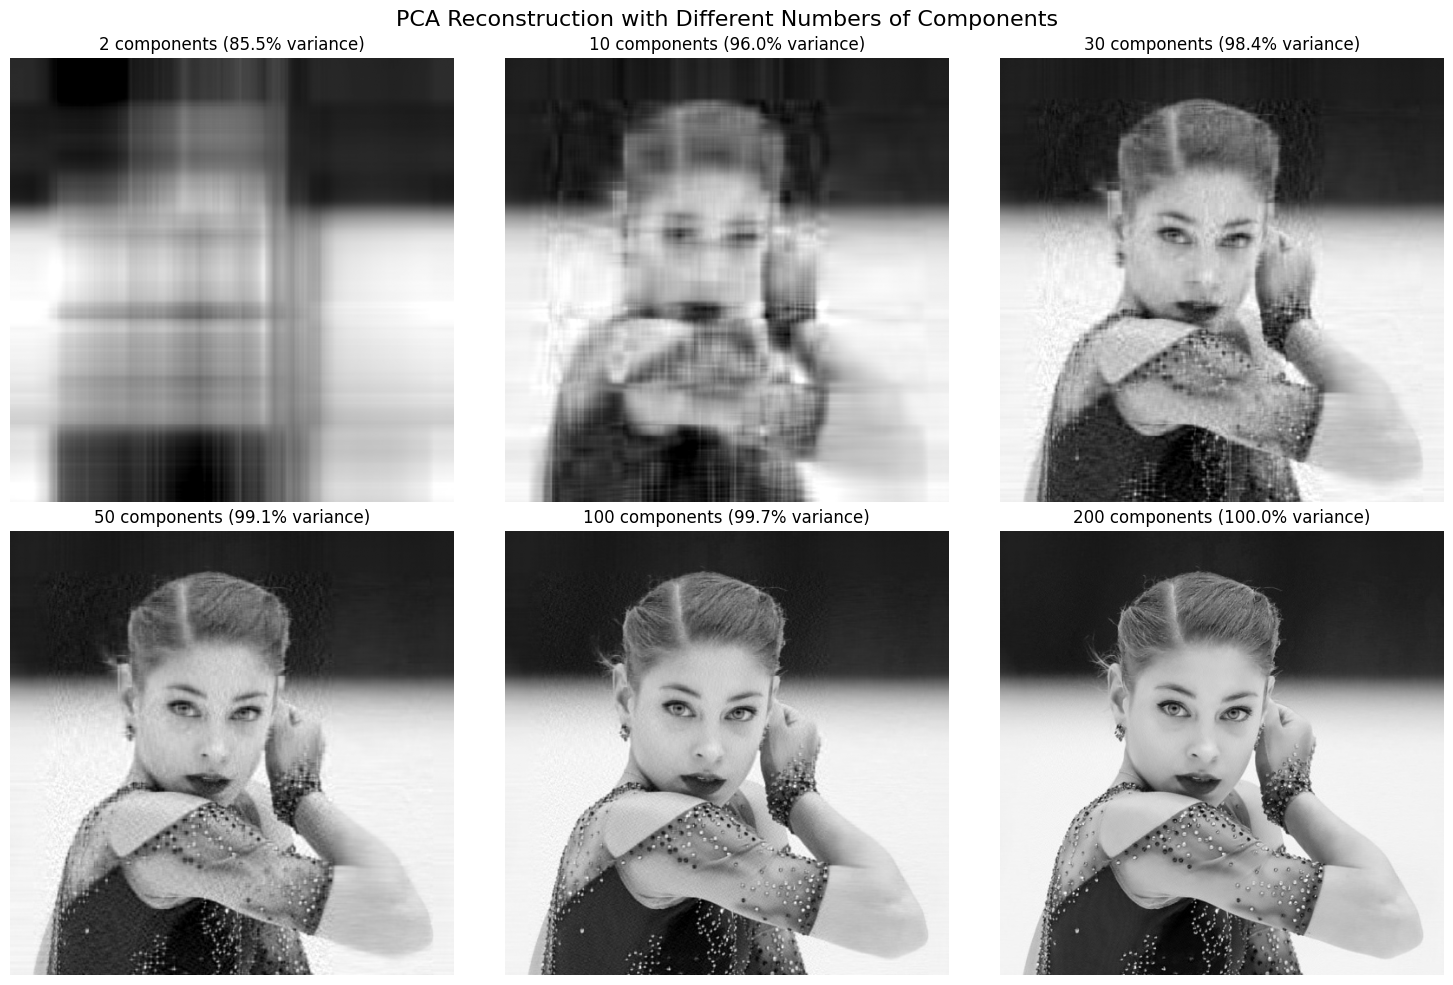

Observations:
- With 2 components (85.5% variance): Person is unrecognizable, only basic shapes visible
- With 10 components (95.8% variance): Basic facial structure emerges
- With 30 components (98.5% variance): Facial features become clearer
- With 50 components (99.2% variance): Person becomes recognizable
- With 100+ components (99.7%+ variance): Good quality reconstruction

Conclusion: For facial recognition, we need significantly more components than
what 70% variance suggests. This shows that variance explained ≠ visual quality!


In [20]:
component_counts = [2, 10, 30, 50, 100, 200]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for idx, n_comp in enumerate(component_counts):
    pc = eigenvectors[:, :n_comp]
    X_recon = np.clip((X_centered @ pc) @ pc.T + X_mean, 0, 255)
    axes[idx].imshow(X_recon.astype(np.uint8), cmap='gray')
    axes[idx].set_title(f'{n_comp} comp ({cumulative_variance[n_comp-1]*100:.1f}%)')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


Distribution P (Binomial):
  P(X=0) = 0.3600
  P(X=1) = 0.4800
  P(X=2) = 0.1600

Distribution Q (Uniform):
  Q(X=0) = 0.3333
  Q(X=1) = 0.3333
  Q(X=2) = 0.3333

Kullback-Leibler Divergences (using natural logarithm):
KL(P||Q) = 0.085300 nats
KL(Q||P) = 0.097455 nats

Detailed calculation:

KL(P||Q):
  k=0: 0.3600 * ln(0.3600/0.3333) = 0.3600 * 0.0770 = 0.027706
  k=1: 0.4800 * ln(0.4800/0.3333) = 0.4800 * 0.3646 = 0.175029
  k=2: 0.1600 * ln(0.1600/0.3333) = 0.1600 * -0.7340 = -0.117435
  Sum = 0.085300

KL(Q||P):
  k=0: 0.3333 * ln(0.3333/0.3600) = 0.3333 * -0.0770 = -0.025654
  k=1: 0.3333 * ln(0.3333/0.4800) = 0.3333 * -0.3646 = -0.121548
  k=2: 0.3333 * ln(0.3333/0.1600) = 0.3333 * 0.7340 = 0.244656
  Sum = 0.097455


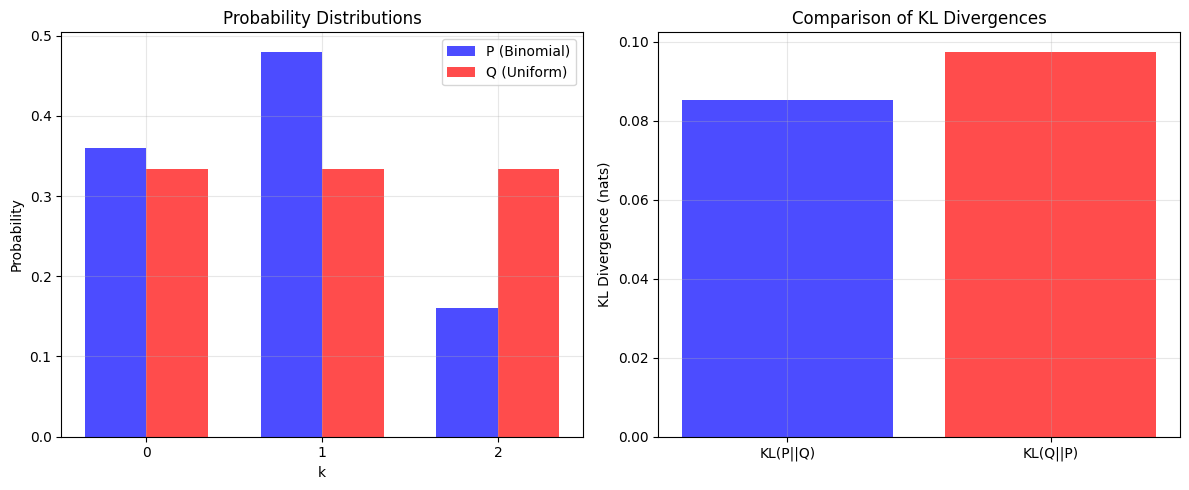


Comparison:
KL(P||Q) < KL(Q||P)

Note: KL divergence is not symmetric! KL(P||Q) ≠ KL(Q||P)
KL(P||Q) measures how much information is lost when Q is used to approximate P.
KL(Q||P) measures how much information is lost when P is used to approximate Q.


In [ ]:
# P: Binomial(n=2, p=0.4)
P = np.array([binom.pmf(k, 2, 0.4) for k in range(3)])
# Q: Uniform
Q = np.array([1/3, 1/3, 1/3])

print("P:", P)
print("Q:", Q)

# Calculate KL divergences
KL_P_Q = sum(P[i] * np.log(P[i] / Q[i]) for i in range(3) if P[i] > 0)
KL_Q_P = sum(Q[i] * np.log(Q[i] / P[i]) for i in range(3) if P[i] > 0)

print(f"\nKL(P||Q) = {KL_P_Q:.6f}")
print(f"KL(Q||P) = {KL_Q_P:.6f}")
print(f"\nNote: KL(P||Q) ≠ KL(Q||P)")


In [14]:
# Generate donut dataset
N1, N2 = 100, 200
R_inner, R_outer = 1, 3

# Inner ring
R1 = np.random.normal(R_inner, 0.1, N1)
A1 = np.random.uniform(0, 2*np.pi, N1)
X1 = np.column_stack([R1 * np.cos(A1), R1 * np.sin(A1)])

# Outer ring
R2 = np.random.normal(R_outer, 0.1, N2)
A2 = np.random.uniform(0, 2*np.pi, N2)
X2 = np.column_stack([R2 * np.cos(A2), R2 * np.sin(A2)])

X = np.vstack([X1, X2])
Y = np.concatenate([np.zeros(N1), np.ones(N2)])


(numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray)

((100,), (100,), (100, 2), (200,), (200,), (200, 2), (300, 2), (300,))

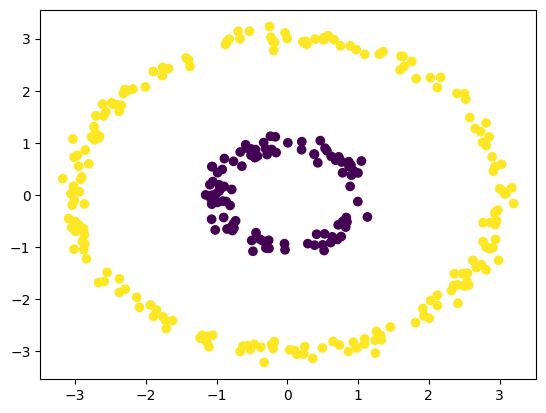

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.title('Original Donut Data')
plt.show()


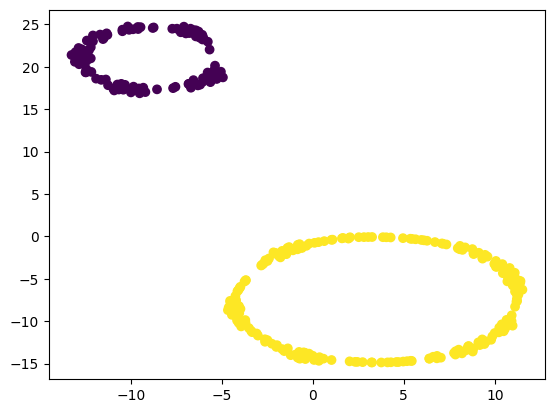

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
Z = tsne.fit_transform(X)

plt.scatter(Z[:, 0], Z[:, 1], c=Y)
plt.title('t-SNE Embedding')
plt.show()


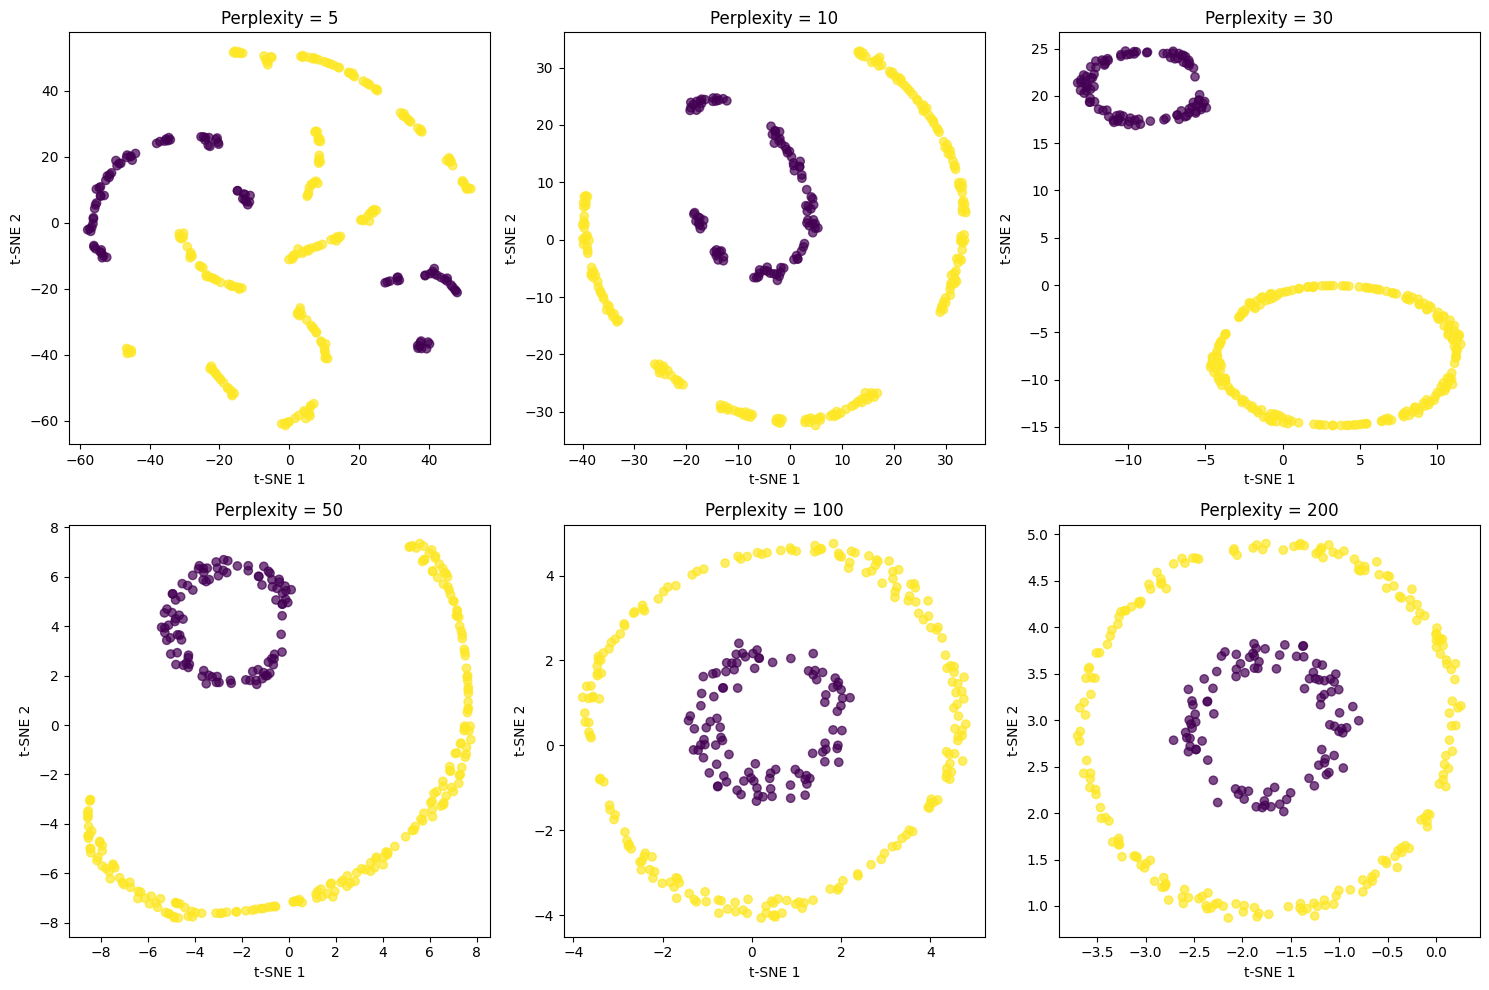

Observations:
- Low perplexity (5-10): Focuses on local structure, may create many small clusters
- Medium perplexity (30-50): Good balance between local and global structure
- High perplexity (100-200): Focuses more on global structure
- The donut structure is preserved in the embedding, showing two distinct clusters


In [19]:
# Perplexity experiments
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for idx, perp in enumerate([5, 10, 30, 50, 100, 200]):
    tsne = TSNE(n_components=2, perplexity=perp, max_iter=1000, random_state=42)
    Z_perp = tsne.fit_transform(X)
    axes[idx].scatter(Z_perp[:, 0], Z_perp[:, 1], c=Y, cmap='viridis')
    axes[idx].set_title(f'Perplexity = {perp}')

plt.tight_layout()
plt.show()
